# Trabalho #5 - Classificação de Múltiplas Classes + Optuna


## Coloque aqui o seu nome

Nome: Gabriel Silvestre Mancini


In [62]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import optuna
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [19]:
# Importa bancos de dados do Keras
from tensorflow.keras.datasets import fashion_mnist

# Carrega dados da Fashion-MNIST em tenores
(X_train_orig, Y_train_orig), (xx, yy) = fashion_mnist.load_data()

classes = ['camiseta','calça','pulover','vestido','casaco','sandália','camisa','tênis','bolsa','bota']

print("X_train shape:", X_train_orig.shape, "y_train shape:", Y_train_orig.shape)

X_train shape: (60000, 28, 28) y_train shape: (60000,)


y = 6


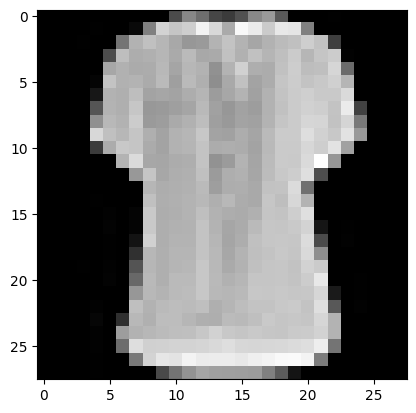

In [20]:
# Exemplo de uma imagem
index = 55
plt.imshow(X_train_orig[index], cmap='gray')
print ("y = " + str(np.squeeze(Y_train_orig[index])))

In [21]:
# PARA VOCÊ FAZER: Divisão dos dados de treinamento em dados de treinamento e validação

# Gera vetor de indíces (números inteiros) de 0 a 59.999 com ordenamento aletório
ind = np.random.randint(60000, size=60000)

# Dados de entrada
### COMECE AQUI ### (≈ 3 linhas)
X_train = X_train_orig[ind[:10000]]
X_val = X_train_orig[ind[10000:12000]]
X_test = X_train_orig[ind[12000:14000]]
### TERMINE AQUI ###

# Dados de saída
### COMECE AQUI ### (≈ 3 linhas)
Y_train = Y_train_orig[ind[:10000]]
Y_val = Y_train_orig[ind[10000:12000]]
Y_test = Y_train_orig[ind[12000:14000]]
### TERMINE AQUI ###

# Acerta dimensões dos vetores de saída
Y_train = Y_train.reshape((Y_train.shape[0], 1))
Y_val = Y_val.reshape((Y_val.shape[0], 1))
Y_test = Y_test.reshape((Y_test.shape[0], 1))

print("Dimensão do tensor de dados de entrada de treinamento =", X_train.shape)
print("Dimensão do tensor de dados de entrada de validação =", X_val.shape)
print("Dimensão do tensor de dados de saída de treinamento =", Y_train.shape)
print("Dimensão do tensor de dados de saída de validação =", Y_val.shape)
print("Dimensão do tensor de dados de saída de test =", Y_test.shape)

Dimensão do tensor de dados de entrada de treinamento = (10000, 28, 28)
Dimensão do tensor de dados de entrada de validação = (2000, 28, 28)
Dimensão do tensor de dados de saída de treinamento = (10000, 1)
Dimensão do tensor de dados de saída de validação = (2000, 1)
Dimensão do tensor de dados de saída de test = (2000, 1)


In [22]:
# PARA VOCÊ FAZER: Normalização dos dados de entrada

# Guarda dimensão das imagens
num_px = X_train.shape[1]
print("Numero de colunas e linhas das imagens de entrada=", num_px)

# Transformação dos dados em números reais
### Comece AQUI ### (≈ 3 linhas)
X_train_float = X_train.astype('float32')/255.0
X_val_float = X_val.astype('float32')/255.0
X_test_float = X_test.astype('float32')/255.0
### TERMINE AQUI ###

# Redimensionamento dos dados de entrada
### COMECE AQUI ### (≈ 6 linhas)
#m_train
X_train_flat = X_train_float.reshape(X_train_float.shape[0], num_px * num_px)
#m_test
X_test_flat = X_test_float.reshape(X_test_float.shape[0], num_px * num_px)
#m_val
X_val_flat = X_val_float.reshape(X_val_float.shape[0], num_px * num_px)
### TERMINE AQUI ###

# Dimensão dos tensores de dados
print('Dimensão dos dados de entrada do conjunto de treinamento: ', X_train_flat.shape)
print('Dimensão dos dados de entrada do conjunto de validação: ', X_test_flat.shape)
print('Dimensão dos dados de entrada do conjunto de teste: ', X_test_flat.shape)

# Para verificar se os resultados estão corretos
print("Alguns elementos da primeira imagem de treinamento = ", X_train_flat[14,10:15])
print("Alguns elementos da primeira imagem de validação = ", X_val_flat[14,10:15])
print("Alguns elementos da primeira imagem de teste = ", X_test_flat[14,10:15])

Numero de colunas e linhas das imagens de entrada= 28
Dimensão dos dados de entrada do conjunto de treinamento:  (10000, 784)
Dimensão dos dados de entrada do conjunto de validação:  (2000, 784)
Dimensão dos dados de entrada do conjunto de teste:  (2000, 784)
Alguns elementos da primeira imagem de treinamento =  [0.29803923 0.31764707 0.2        0.0627451  0.09803922]
Alguns elementos da primeira imagem de validação =  [0. 0. 0. 0. 0.]
Alguns elementos da primeira imagem de teste =  [0.03529412 0.5803922  0.65882355 0.60784316 0.6431373 ]


Classe numérica:  [8] , Vetor de saída correspondentes:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


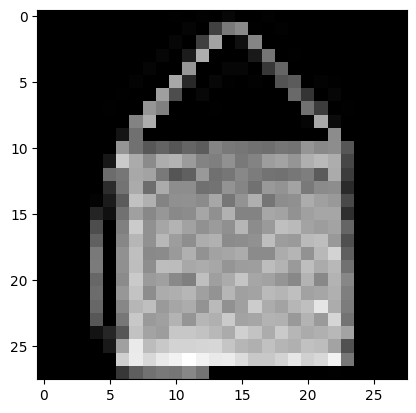

In [24]:
# Exemplo de saída
index = 100
print("Classe numérica: ", Y_train[index], ", Vetor de saída correspondentes: ", Y_train_hot[index])
plt.imshow(X_train[index], cmap='gray', vmin=0, vmax=255)

In [75]:
# prompt: create a function that generates and trains a nn model based on a set of hyperparameters

def create_and_train_model(optimizer, loss_fn, metrics, epochs, layers):
  """
  Generates and trains a neural network model based on given hyperparameters.

  Args:
    optimizer: The optimizer to use for training.
    loss_fn: The loss function to use for training.
    metrics: A list of metrics to evaluate the model.
    epochs: The number of epochs to train the model.
    layers: A list of tuples representing the layers in the model.
             Each tuple contains (number of units, activation function).

  Returns:
    The trained model.
  """
  model = keras.Sequential()
  # Add input layer
  model.add(keras.layers.InputLayer(input_shape=(784,)))
  # Add hidden layers
  for units, activation in layers:
    model.add(keras.layers.Dense(units, activation=activation))
    model.add(keras.layers.Dropout(0.5))

  # Add output layer
  model.add(keras.layers.Dense(10, activation='softmax'))

  model.compile(optimizer=optimizer,
                loss=loss_fn,
                metrics=metrics)

  # Definindo o Early Stopping
  callbacks = []
  early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
  callbacks.append(early_stopping)

  model.fit(X_train_flat, Y_train_hot, epochs=epochs, callbacks=callbacks, verbose=0)
  return model

In [78]:
def objective(trial):
  # Define the search space for hyperparameters
  optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd"])
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  if optimizer_name == "adam":
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  else:
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

  loss_fn = "categorical_crossentropy"
  metrics = ["accuracy"]
  epochs = trial.suggest_int("epochs", 5, 30)

  # Define the search space for the number of layers and units per layer
  n_layers = trial.suggest_int("n_layers", 1, 5)
  layers = []
  for i in range(n_layers):
    units = trial.suggest_int(f"units_{i}", 32, 128)
    activation = trial.suggest_categorical(f"activation_{i}", ["relu", "sigmoid"])
    layers.append((units, activation))

  print(f"Trial hyperparameters: optimizer={optimizer_name}, learning_rate={learning_rate}, epochs={epochs}, layers={layers}")

  # Create and train the model
  model = create_and_train_model(optimizer, loss_fn, metrics, epochs, layers)

  # Evaluate the model
  _, accuracy = model.evaluate(X_test_flat, Y_test_hot, verbose=0)
  return accuracy


In [79]:
# Criando o estudo e rodando a otimização
study = optuna.create_study(direction='maximize')  # Maximizar a acurácia
study.optimize(objective, n_trials=50)  # Executar 50 tentativas

# Melhor conjunto de hiperparâmetros
print("Melhores hiperparâmetros:", study.best_params)
print(f"Melhor acurácia:{study.best_value}")

[I 2024-10-04 01:01:48,268] A new study created in memory with name: no-name-f234ed9b-292b-4c7e-b1b5-fc66a6cdcbe8


Trial hyperparameters: optimizer=sgd, learning_rate=0.011596241103150683, epochs=6, layers=[(48, 'relu'), (61, 'sigmoid'), (105, 'relu')]


[I 2024-10-04 01:01:58,176] Trial 0 finished with value: 0.5534999966621399 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.011596241103150683, 'epochs': 6, 'n_layers': 3, 'units_0': 48, 'activation_0': 'relu', 'units_1': 61, 'activation_1': 'sigmoid', 'units_2': 105, 'activation_2': 'relu'}. Best is trial 0 with value: 0.5534999966621399.


Trial hyperparameters: optimizer=adam, learning_rate=0.00012530197534100262, epochs=18, layers=[(101, 'sigmoid'), (100, 'sigmoid'), (69, 'sigmoid')]


[I 2024-10-04 01:02:23,331] Trial 1 finished with value: 0.6010000109672546 and parameters: {'optimizer': 'adam', 'learning_rate': 0.00012530197534100262, 'epochs': 18, 'n_layers': 3, 'units_0': 101, 'activation_0': 'sigmoid', 'units_1': 100, 'activation_1': 'sigmoid', 'units_2': 69, 'activation_2': 'sigmoid'}. Best is trial 1 with value: 0.6010000109672546.


Trial hyperparameters: optimizer=sgd, learning_rate=3.8710827642131336e-05, epochs=16, layers=[(41, 'relu'), (54, 'sigmoid'), (64, 'sigmoid'), (111, 'relu'), (34, 'relu')]


[I 2024-10-04 01:02:41,806] Trial 2 finished with value: 0.11500000208616257 and parameters: {'optimizer': 'sgd', 'learning_rate': 3.8710827642131336e-05, 'epochs': 16, 'n_layers': 5, 'units_0': 41, 'activation_0': 'relu', 'units_1': 54, 'activation_1': 'sigmoid', 'units_2': 64, 'activation_2': 'sigmoid', 'units_3': 111, 'activation_3': 'relu', 'units_4': 34, 'activation_4': 'relu'}. Best is trial 1 with value: 0.6010000109672546.


Trial hyperparameters: optimizer=adam, learning_rate=8.30607514180888e-05, epochs=26, layers=[(44, 'sigmoid')]


[I 2024-10-04 01:03:00,686] Trial 3 finished with value: 0.7894999980926514 and parameters: {'optimizer': 'adam', 'learning_rate': 8.30607514180888e-05, 'epochs': 26, 'n_layers': 1, 'units_0': 44, 'activation_0': 'sigmoid'}. Best is trial 3 with value: 0.7894999980926514.


Trial hyperparameters: optimizer=sgd, learning_rate=0.002438268992158287, epochs=25, layers=[(117, 'relu'), (51, 'relu')]


[I 2024-10-04 01:03:21,729] Trial 4 finished with value: 0.7680000066757202 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.002438268992158287, 'epochs': 25, 'n_layers': 2, 'units_0': 117, 'activation_0': 'relu', 'units_1': 51, 'activation_1': 'relu'}. Best is trial 3 with value: 0.7894999980926514.


Trial hyperparameters: optimizer=adam, learning_rate=0.009905950216946915, epochs=12, layers=[(85, 'relu'), (70, 'relu'), (118, 'relu')]


[I 2024-10-04 01:03:40,375] Trial 5 finished with value: 0.4259999990463257 and parameters: {'optimizer': 'adam', 'learning_rate': 0.009905950216946915, 'epochs': 12, 'n_layers': 3, 'units_0': 85, 'activation_0': 'relu', 'units_1': 70, 'activation_1': 'relu', 'units_2': 118, 'activation_2': 'relu'}. Best is trial 3 with value: 0.7894999980926514.


Trial hyperparameters: optimizer=sgd, learning_rate=6.357322916522396e-05, epochs=16, layers=[(46, 'sigmoid'), (73, 'sigmoid'), (82, 'relu')]


[I 2024-10-04 01:03:55,835] Trial 6 finished with value: 0.09149999916553497 and parameters: {'optimizer': 'sgd', 'learning_rate': 6.357322916522396e-05, 'epochs': 16, 'n_layers': 3, 'units_0': 46, 'activation_0': 'sigmoid', 'units_1': 73, 'activation_1': 'sigmoid', 'units_2': 82, 'activation_2': 'relu'}. Best is trial 3 with value: 0.7894999980926514.


Trial hyperparameters: optimizer=adam, learning_rate=1.2263638106340946e-05, epochs=14, layers=[(97, 'relu'), (91, 'sigmoid'), (56, 'relu'), (54, 'sigmoid')]


[I 2024-10-04 01:04:16,364] Trial 7 finished with value: 0.3725000023841858 and parameters: {'optimizer': 'adam', 'learning_rate': 1.2263638106340946e-05, 'epochs': 14, 'n_layers': 4, 'units_0': 97, 'activation_0': 'relu', 'units_1': 91, 'activation_1': 'sigmoid', 'units_2': 56, 'activation_2': 'relu', 'units_3': 54, 'activation_3': 'sigmoid'}. Best is trial 3 with value: 0.7894999980926514.


Trial hyperparameters: optimizer=sgd, learning_rate=0.01211267124196693, epochs=22, layers=[(87, 'sigmoid'), (54, 'relu'), (46, 'sigmoid'), (89, 'sigmoid'), (119, 'relu')]


[I 2024-10-04 01:04:42,470] Trial 8 finished with value: 0.10350000113248825 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.01211267124196693, 'epochs': 22, 'n_layers': 5, 'units_0': 87, 'activation_0': 'sigmoid', 'units_1': 54, 'activation_1': 'relu', 'units_2': 46, 'activation_2': 'sigmoid', 'units_3': 89, 'activation_3': 'sigmoid', 'units_4': 119, 'activation_4': 'relu'}. Best is trial 3 with value: 0.7894999980926514.


Trial hyperparameters: optimizer=sgd, learning_rate=6.729571745644979e-05, epochs=5, layers=[(73, 'sigmoid')]


[I 2024-10-04 01:04:48,772] Trial 9 finished with value: 0.09749999642372131 and parameters: {'optimizer': 'sgd', 'learning_rate': 6.729571745644979e-05, 'epochs': 5, 'n_layers': 1, 'units_0': 73, 'activation_0': 'sigmoid'}. Best is trial 3 with value: 0.7894999980926514.


Trial hyperparameters: optimizer=adam, learning_rate=0.0005464600121244714, epochs=30, layers=[(66, 'sigmoid')]


[I 2024-10-04 01:05:10,449] Trial 10 finished with value: 0.8454999923706055 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0005464600121244714, 'epochs': 30, 'n_layers': 1, 'units_0': 66, 'activation_0': 'sigmoid'}. Best is trial 10 with value: 0.8454999923706055.


Trial hyperparameters: optimizer=adam, learning_rate=0.0004868758802808869, epochs=30, layers=[(61, 'sigmoid')]


[I 2024-10-04 01:05:31,670] Trial 11 finished with value: 0.8410000205039978 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0004868758802808869, 'epochs': 30, 'n_layers': 1, 'units_0': 61, 'activation_0': 'sigmoid'}. Best is trial 10 with value: 0.8454999923706055.


Trial hyperparameters: optimizer=adam, learning_rate=0.000642620009907291, epochs=30, layers=[(67, 'sigmoid')]


[I 2024-10-04 01:05:55,749] Trial 12 finished with value: 0.8485000133514404 and parameters: {'optimizer': 'adam', 'learning_rate': 0.000642620009907291, 'epochs': 30, 'n_layers': 1, 'units_0': 67, 'activation_0': 'sigmoid'}. Best is trial 12 with value: 0.8485000133514404.


Trial hyperparameters: optimizer=adam, learning_rate=0.0010072297004842144, epochs=30, layers=[(64, 'sigmoid'), (124, 'relu')]


[I 2024-10-04 01:06:19,969] Trial 13 finished with value: 0.8450000286102295 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0010072297004842144, 'epochs': 30, 'n_layers': 2, 'units_0': 64, 'activation_0': 'sigmoid', 'units_1': 124, 'activation_1': 'relu'}. Best is trial 12 with value: 0.8485000133514404.


Trial hyperparameters: optimizer=adam, learning_rate=0.0005052408185573944, epochs=26, layers=[(63, 'sigmoid'), (33, 'relu')]


[I 2024-10-04 01:06:41,093] Trial 14 finished with value: 0.8245000243186951 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0005052408185573944, 'epochs': 26, 'n_layers': 2, 'units_0': 63, 'activation_0': 'sigmoid', 'units_1': 33, 'activation_1': 'relu'}. Best is trial 12 with value: 0.8485000133514404.


Trial hyperparameters: optimizer=adam, learning_rate=0.08144263130370927, epochs=22, layers=[(72, 'sigmoid')]


[I 2024-10-04 01:06:57,345] Trial 15 finished with value: 0.6769999861717224 and parameters: {'optimizer': 'adam', 'learning_rate': 0.08144263130370927, 'epochs': 22, 'n_layers': 1, 'units_0': 72, 'activation_0': 'sigmoid'}. Best is trial 12 with value: 0.8485000133514404.


Trial hyperparameters: optimizer=adam, learning_rate=0.0024469913886628054, epochs=30, layers=[(32, 'sigmoid'), (125, 'relu')]


[I 2024-10-04 01:07:21,659] Trial 16 finished with value: 0.8414999842643738 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0024469913886628054, 'epochs': 30, 'n_layers': 2, 'units_0': 32, 'activation_0': 'sigmoid', 'units_1': 125, 'activation_1': 'relu'}. Best is trial 12 with value: 0.8485000133514404.


Trial hyperparameters: optimizer=adam, learning_rate=0.0002636276901749259, epochs=23, layers=[(56, 'sigmoid')]


[I 2024-10-04 01:07:41,314] Trial 17 finished with value: 0.8184999823570251 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0002636276901749259, 'epochs': 23, 'n_layers': 1, 'units_0': 56, 'activation_0': 'sigmoid'}. Best is trial 12 with value: 0.8485000133514404.


Trial hyperparameters: optimizer=adam, learning_rate=0.0022834832937260055, epochs=27, layers=[(76, 'sigmoid'), (109, 'sigmoid')]


[I 2024-10-04 01:08:04,118] Trial 18 finished with value: 0.8514999747276306 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0022834832937260055, 'epochs': 27, 'n_layers': 2, 'units_0': 76, 'activation_0': 'sigmoid', 'units_1': 109, 'activation_1': 'sigmoid'}. Best is trial 18 with value: 0.8514999747276306.


Trial hyperparameters: optimizer=adam, learning_rate=0.0032077038717423447, epochs=19, layers=[(126, 'sigmoid'), (105, 'sigmoid')]


[I 2024-10-04 01:08:22,196] Trial 19 finished with value: 0.8504999876022339 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0032077038717423447, 'epochs': 19, 'n_layers': 2, 'units_0': 126, 'activation_0': 'sigmoid', 'units_1': 105, 'activation_1': 'sigmoid'}. Best is trial 18 with value: 0.8514999747276306.


Trial hyperparameters: optimizer=adam, learning_rate=0.03399715391385452, epochs=9, layers=[(127, 'sigmoid'), (106, 'sigmoid'), (33, 'sigmoid'), (36, 'relu')]


[I 2024-10-04 01:08:42,781] Trial 20 finished with value: 0.09300000220537186 and parameters: {'optimizer': 'adam', 'learning_rate': 0.03399715391385452, 'epochs': 9, 'n_layers': 4, 'units_0': 127, 'activation_0': 'sigmoid', 'units_1': 106, 'activation_1': 'sigmoid', 'units_2': 33, 'activation_2': 'sigmoid', 'units_3': 36, 'activation_3': 'relu'}. Best is trial 18 with value: 0.8514999747276306.


Trial hyperparameters: optimizer=adam, learning_rate=0.0023089423537502414, epochs=27, layers=[(97, 'sigmoid'), (111, 'sigmoid')]


[I 2024-10-04 01:09:04,971] Trial 21 finished with value: 0.8544999957084656 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0023089423537502414, 'epochs': 27, 'n_layers': 2, 'units_0': 97, 'activation_0': 'sigmoid', 'units_1': 111, 'activation_1': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.0020051290506108484, epochs=19, layers=[(108, 'sigmoid'), (111, 'sigmoid')]


[I 2024-10-04 01:09:22,916] Trial 22 finished with value: 0.8420000076293945 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0020051290506108484, 'epochs': 19, 'n_layers': 2, 'units_0': 108, 'activation_0': 'sigmoid', 'units_1': 111, 'activation_1': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.005887642081704168, epochs=27, layers=[(121, 'sigmoid'), (89, 'sigmoid')]


[I 2024-10-04 01:09:45,837] Trial 23 finished with value: 0.8374999761581421 and parameters: {'optimizer': 'adam', 'learning_rate': 0.005887642081704168, 'epochs': 27, 'n_layers': 2, 'units_0': 121, 'activation_0': 'sigmoid', 'units_1': 89, 'activation_1': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.005404962073584575, epochs=20, layers=[(97, 'sigmoid'), (113, 'sigmoid')]


[I 2024-10-04 01:10:03,147] Trial 24 finished with value: 0.8370000123977661 and parameters: {'optimizer': 'adam', 'learning_rate': 0.005404962073584575, 'epochs': 20, 'n_layers': 2, 'units_0': 97, 'activation_0': 'sigmoid', 'units_1': 113, 'activation_1': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.001402758183856086, epochs=24, layers=[(81, 'sigmoid'), (97, 'sigmoid'), (90, 'sigmoid'), (119, 'relu')]


[I 2024-10-04 01:10:31,390] Trial 25 finished with value: 0.7820000052452087 and parameters: {'optimizer': 'adam', 'learning_rate': 0.001402758183856086, 'epochs': 24, 'n_layers': 4, 'units_0': 81, 'activation_0': 'sigmoid', 'units_1': 97, 'activation_1': 'sigmoid', 'units_2': 90, 'activation_2': 'sigmoid', 'units_3': 119, 'activation_3': 'relu'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.003989298934522288, epochs=28, layers=[(109, 'relu'), (112, 'sigmoid')]


[I 2024-10-04 01:10:55,337] Trial 26 finished with value: 0.8374999761581421 and parameters: {'optimizer': 'adam', 'learning_rate': 0.003989298934522288, 'epochs': 28, 'n_layers': 2, 'units_0': 109, 'activation_0': 'relu', 'units_1': 112, 'activation_1': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.023257848469513436, epochs=21, layers=[(90, 'sigmoid'), (84, 'sigmoid'), (125, 'relu')]


[I 2024-10-04 01:11:20,959] Trial 27 finished with value: 0.5669999718666077 and parameters: {'optimizer': 'adam', 'learning_rate': 0.023257848469513436, 'epochs': 21, 'n_layers': 3, 'units_0': 90, 'activation_0': 'sigmoid', 'units_1': 84, 'activation_1': 'sigmoid', 'units_2': 125, 'activation_2': 'relu'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.00020947120851167364, epochs=28, layers=[(113, 'sigmoid'), (119, 'sigmoid')]


[I 2024-10-04 01:11:43,957] Trial 28 finished with value: 0.8190000057220459 and parameters: {'optimizer': 'adam', 'learning_rate': 0.00020947120851167364, 'epochs': 28, 'n_layers': 2, 'units_0': 113, 'activation_0': 'sigmoid', 'units_1': 119, 'activation_1': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=sgd, learning_rate=0.012140935688561233, epochs=9, layers=[(127, 'relu'), (103, 'sigmoid'), (103, 'sigmoid')]


[I 2024-10-04 01:11:56,678] Trial 29 finished with value: 0.5339999794960022 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.012140935688561233, 'epochs': 9, 'n_layers': 3, 'units_0': 127, 'activation_0': 'relu', 'units_1': 103, 'activation_1': 'sigmoid', 'units_2': 103, 'activation_2': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.003413186396687941, epochs=24, layers=[(75, 'sigmoid'), (95, 'sigmoid'), (34, 'relu')]


[I 2024-10-04 01:12:26,371] Trial 30 finished with value: 0.7940000295639038 and parameters: {'optimizer': 'adam', 'learning_rate': 0.003413186396687941, 'epochs': 24, 'n_layers': 3, 'units_0': 75, 'activation_0': 'sigmoid', 'units_1': 95, 'activation_1': 'sigmoid', 'units_2': 34, 'activation_2': 'relu'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.0008425837302051828, epochs=28, layers=[(52, 'sigmoid')]


[I 2024-10-04 01:12:45,502] Trial 31 finished with value: 0.8379999995231628 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0008425837302051828, 'epochs': 28, 'n_layers': 1, 'units_0': 52, 'activation_0': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.0013740053961579831, epochs=28, layers=[(93, 'sigmoid'), (119, 'sigmoid')]


[I 2024-10-04 01:13:08,087] Trial 32 finished with value: 0.8495000004768372 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0013740053961579831, 'epochs': 28, 'n_layers': 2, 'units_0': 93, 'activation_0': 'sigmoid', 'units_1': 119, 'activation_1': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.0013966442880989026, epochs=25, layers=[(94, 'sigmoid'), (116, 'sigmoid')]


[I 2024-10-04 01:13:29,437] Trial 33 finished with value: 0.8519999980926514 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0013966442880989026, 'epochs': 25, 'n_layers': 2, 'units_0': 94, 'activation_0': 'sigmoid', 'units_1': 116, 'activation_1': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.00025212931227047263, epochs=18, layers=[(104, 'sigmoid'), (107, 'sigmoid')]


[I 2024-10-04 01:13:46,770] Trial 34 finished with value: 0.8025000095367432 and parameters: {'optimizer': 'adam', 'learning_rate': 0.00025212931227047263, 'epochs': 18, 'n_layers': 2, 'units_0': 104, 'activation_0': 'sigmoid', 'units_1': 107, 'activation_1': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.006632298018079563, epochs=24, layers=[(80, 'sigmoid'), (128, 'sigmoid'), (90, 'sigmoid')]


[I 2024-10-04 01:14:13,629] Trial 35 finished with value: 0.7994999885559082 and parameters: {'optimizer': 'adam', 'learning_rate': 0.006632298018079563, 'epochs': 24, 'n_layers': 3, 'units_0': 80, 'activation_0': 'sigmoid', 'units_1': 128, 'activation_1': 'sigmoid', 'units_2': 90, 'activation_2': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=sgd, learning_rate=0.0021730217223732366, epochs=25, layers=[(102, 'relu'), (118, 'sigmoid')]


[I 2024-10-04 01:14:34,050] Trial 36 finished with value: 0.6980000138282776 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.0021730217223732366, 'epochs': 25, 'n_layers': 2, 'units_0': 102, 'activation_0': 'relu', 'units_1': 118, 'activation_1': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.001396252047711245, epochs=26, layers=[(120, 'sigmoid'), (104, 'sigmoid'), (110, 'relu')]


[I 2024-10-04 01:15:01,615] Trial 37 finished with value: 0.840499997138977 and parameters: {'optimizer': 'adam', 'learning_rate': 0.001396252047711245, 'epochs': 26, 'n_layers': 3, 'units_0': 120, 'activation_0': 'sigmoid', 'units_1': 104, 'activation_1': 'sigmoid', 'units_2': 110, 'activation_2': 'relu'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.021769461634573842, epochs=16, layers=[(84, 'relu'), (115, 'sigmoid')]


[I 2024-10-04 01:15:19,826] Trial 38 finished with value: 0.6610000133514404 and parameters: {'optimizer': 'adam', 'learning_rate': 0.021769461634573842, 'epochs': 16, 'n_layers': 2, 'units_0': 84, 'activation_0': 'relu', 'units_1': 115, 'activation_1': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=sgd, learning_rate=0.008310621566445645, epochs=14, layers=[(94, 'sigmoid'), (82, 'sigmoid'), (75, 'relu')]


[I 2024-10-04 01:15:34,534] Trial 39 finished with value: 0.1850000023841858 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.008310621566445645, 'epochs': 14, 'n_layers': 3, 'units_0': 94, 'activation_0': 'sigmoid', 'units_1': 82, 'activation_1': 'sigmoid', 'units_2': 75, 'activation_2': 'relu'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.003930603158972914, epochs=20, layers=[(112, 'sigmoid'), (109, 'sigmoid')]


[I 2024-10-04 01:15:52,321] Trial 40 finished with value: 0.8374999761581421 and parameters: {'optimizer': 'adam', 'learning_rate': 0.003930603158972914, 'epochs': 20, 'n_layers': 2, 'units_0': 112, 'activation_0': 'sigmoid', 'units_1': 109, 'activation_1': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.001149501187502298, epochs=27, layers=[(90, 'sigmoid'), (118, 'sigmoid')]


[I 2024-10-04 01:16:13,325] Trial 41 finished with value: 0.8479999899864197 and parameters: {'optimizer': 'adam', 'learning_rate': 0.001149501187502298, 'epochs': 27, 'n_layers': 2, 'units_0': 90, 'activation_0': 'sigmoid', 'units_1': 118, 'activation_1': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.001770312302498647, epochs=28, layers=[(95, 'sigmoid'), (123, 'sigmoid')]


[I 2024-10-04 01:16:35,534] Trial 42 finished with value: 0.8475000262260437 and parameters: {'optimizer': 'adam', 'learning_rate': 0.001770312302498647, 'epochs': 28, 'n_layers': 2, 'units_0': 95, 'activation_0': 'sigmoid', 'units_1': 123, 'activation_1': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.0035548363583465157, epochs=25, layers=[(78, 'sigmoid'), (98, 'sigmoid')]


[I 2024-10-04 01:16:56,890] Trial 43 finished with value: 0.8485000133514404 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0035548363583465157, 'epochs': 25, 'n_layers': 2, 'units_0': 78, 'activation_0': 'sigmoid', 'units_1': 98, 'activation_1': 'sigmoid'}. Best is trial 21 with value: 0.8544999957084656.


Trial hyperparameters: optimizer=adam, learning_rate=0.0008989455875414375, epochs=27, layers=[(90, 'sigmoid')]


[I 2024-10-04 01:17:15,956] Trial 44 finished with value: 0.8575000166893005 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0008989455875414375, 'epochs': 27, 'n_layers': 1, 'units_0': 90, 'activation_0': 'sigmoid'}. Best is trial 44 with value: 0.8575000166893005.


Trial hyperparameters: optimizer=sgd, learning_rate=0.0003626909640279266, epochs=22, layers=[(101, 'sigmoid')]


[I 2024-10-04 01:17:31,879] Trial 45 finished with value: 0.5669999718666077 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.0003626909640279266, 'epochs': 22, 'n_layers': 1, 'units_0': 101, 'activation_0': 'sigmoid'}. Best is trial 44 with value: 0.8575000166893005.


Trial hyperparameters: optimizer=adam, learning_rate=0.0006505050104033976, epochs=26, layers=[(85, 'relu')]


[I 2024-10-04 01:17:51,164] Trial 46 finished with value: 0.8544999957084656 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0006505050104033976, 'epochs': 26, 'n_layers': 1, 'units_0': 85, 'activation_0': 'relu'}. Best is trial 44 with value: 0.8575000166893005.


Trial hyperparameters: optimizer=adam, learning_rate=0.00015079443997624253, epochs=26, layers=[(86, 'relu')]


[I 2024-10-04 01:18:10,661] Trial 47 finished with value: 0.843500018119812 and parameters: {'optimizer': 'adam', 'learning_rate': 0.00015079443997624253, 'epochs': 26, 'n_layers': 1, 'units_0': 86, 'activation_0': 'relu'}. Best is trial 44 with value: 0.8575000166893005.


Trial hyperparameters: optimizer=adam, learning_rate=0.000850193884583163, epochs=29, layers=[(71, 'relu')]


[I 2024-10-04 01:18:30,981] Trial 48 finished with value: 0.8600000143051147 and parameters: {'optimizer': 'adam', 'learning_rate': 0.000850193884583163, 'epochs': 29, 'n_layers': 1, 'units_0': 71, 'activation_0': 'relu'}. Best is trial 48 with value: 0.8600000143051147.


Trial hyperparameters: optimizer=adam, learning_rate=0.0007338217235869363, epochs=29, layers=[(70, 'relu')]


[I 2024-10-04 01:18:52,675] Trial 49 finished with value: 0.8560000061988831 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0007338217235869363, 'epochs': 29, 'n_layers': 1, 'units_0': 70, 'activation_0': 'relu'}. Best is trial 48 with value: 0.8600000143051147.


Melhores hiperparâmetros: {'optimizer': 'adam', 'learning_rate': 0.000850193884583163, 'epochs': 29, 'n_layers': 1, 'units_0': 71, 'activation_0': 'relu'}
Melhor acurácia:0.8600000143051147


In [87]:
import optuna
from optuna.visualization import (plot_param_importances, plot_optimization_history,
                                  plot_contour, plot_parallel_coordinate,
                                  plot_slice, plot_intermediate_values)

# Suponha que você já criou e executou o estudo com Optuna
# Exemplo: study = optuna.create_study(direction='minimize')
#          study.optimize(objective, n_trials=100)

# 1. Parâmetros Importantes
plot_param_importances(study)

In [88]:
# 2. Histórico da Otimização
plot_optimization_history(study)

In [89]:
# 4. Gráfico de Coordenadas Paralelas
plot_parallel_coordinate(study)

In [90]:
# 5. Gráficos Slice
plot_slice(study)

In [91]:
# 6. Valores Intermediários (se aplicável)
plot_intermediate_values(study)

[W 2024-10-04 01:22:30,579] You need to set up the pruning feature to utilize `plot_intermediate_values()`
